In [1]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
import nwdatawrangler as nwd
import nwnetworks as nwn

This is the .csv file we're basing our model on.

This was generated by Sofiane's Bayes model.

In [2]:
csv_file="/home/johnny/Documents/sequential-models/gluon-ts/examples/synth_2020Aug02_190846.csv"

The columns below have some missing data (NaNs), so we'll need to tidy them up a bit.

In [3]:
_cols_with_cat_nans = ['TransactionType', 'MerchantCategory', 'MerchantID', 'TransactionLocation',
                     'TransactionReference', 'TransactionDescription', 'RecipientID']

In [4]:
df = pd.read_csv(csv_file, encoding="latin-1", low_memory=False)

Load up the data. `"latin-1"` refers to the encoding (from a Windows machine). The `low-memory` parameter allows more sophisticated type inference to be performed on the data.

The command below performs some tidying up of the data, such as removing the '£' symbol, and adding a synthetic merchant code (13) to those transactions which don;t have them.

In [5]:
raw_df = nwd.clean_data_frame(df, _cols_with_cat_nans)

Some basic data analysis - we have a number of columns of categorical data, so we can label them as such. Replacing them with their category codes gives us a numnerical value, which the model can do something with.

In [6]:
cat_columns = raw_df.select_dtypes(['category']).columns

In [7]:
raw_df[cat_columns] = raw_df[cat_columns].apply(lambda x: x.cat.codes)

Here we get a list of the accounts ...

In [8]:
_accounts = list(raw_df['AcctID'].unique())

... & for each account, we _fill in the blanks_.

Many of the accounts have gaps in their timeline. For example, they may not have made a transaction on a given day, or there may be gaps for several days. This could prove problematic for creating time series, since it expects data points at a given frequency.

To simplify, and to avoid algorithmic contortions when dealing with timeline gaps, we simply find the current amount in their account and create a _null transaction_, simply noting that no money was spent on that day.

This takes a _long_ time to run ...

In [9]:
df_list = [ nwd.fillInTheBlanks(raw_df, _account) for _account in _accounts ]

Now we concatenate the data into a large dataframe.

In [10]:
big_df = pd.concat(df_list).reset_index(drop=True)

### Normalise the data

Since we're going to be using a number of deep neural networks (DNNs), we need to normalise the data.

This holds generally for time series analysis. The usual procedure is to subtract the mean, and set the variance to one. 

We should also choose which fields we are going to input to the model. The gluon time series library has a number of predefined data types:

Required:

- `start`: start date of the time series
- `target`: values of the time series

We already have a `start` field, which is the timestamp of the transaction. Unfortunately, this has a _daily_ frequency, rather than a timestamp given by the time at which a transaction occurred in terms of hours, minutes and seconds. The lower granularity prevents us from observing, for example, bursts of financial activity. 

The `target` field is going to be the focus of the model, the variable we are trying to forecast. Two candidates, `AccountRunningBalance` & `TransactionAmt`, seem likely candidates for this; we will choose `AccountRunningBalance` as the `target`.

Optional:

- `feat_static_cat`: static (over time) categorical features, list with dimension equal to the number of features
- `feat_static_real`: static (over time) real features, list with dimension equal to the number of features
- `feat_dynamic_cat`: dynamic (over time) categorical features, array with shape equal to (number of features, target length)
- `feat_dynamic_real`: dynamic (over time) real features, array with shape equal to (number of features, target length)

The required fields are pretty self-explanatory. From our point-of-view, given the length of our dataset, the `agegroup` field can be considered `feat_static_cat`, although it will of course change over a longer time period.

Since we have decided that `AccountRunningBalance` is our `target` field, `TransactionAmt` will be our `feat_dynamic_real`.

We also need to normalise the `agegroup` field, which is our static category.

In [11]:
def normaliseColumn(df, col):
    return (df[col] - df[col].mean()) / (df[col].max() - df[col].min()) 

In [12]:
def normaliseByAccount(df, accounts, fields):
    normed_df=[]
    for account in accounts:
        ref_df = df[df['AcctID'] == account]
        for field in fields:
            ref_df[field] = normaliseColumn(ref_df, field)
        normed_df.append(ref_df)
        
    return normed_df

In [13]:
fields = ['AccountRunningBalance', 'TransactionAmt']

In [14]:
list_of_normed_dfs = normaliseByAccount(big_df, _accounts, fields)

/home/johnny/anaconda3/envs/tsa1/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
tmp_df = pd.concat(list_of_normed_dfs).reset_index(drop=True)

In [16]:
tmp_df['agegroup'] = normaliseColumn(tmp_df, 'agegroup')

### Build the datasets

Now, if all that has behaved itself, we can go ahead & build the datasets.

In [17]:
from gluonts.dataset.field_names import FieldName

It's useful to build a meta-data structure that we can refer while building the datasets.

In [18]:
# so let's get the custom_ds_metadata equivalent sorted ...

nw_ds_metadata = {
    'num_series': 123,
    'num_steps': 455,
    'prediction_length': 30,
    'freq': '1D',
    'start': [pd.Timestamp("2018-12-09", freq='1D')
                                for _ in range(455)]    # ?!
}

In [19]:
def getAccountsWithFullHistory(df, accounts):
    account_list=[]
    for account in accounts:
        l = df[df['AcctID'] == account]['AcctID'].count()
        if l == 455:
            account_list.append(account)
            
    return account_list

In [20]:
accts_with_correct_start_date = list(tmp_df[tmp_df['start'] == "2018-12-01"]['AcctID'])

In [21]:
# here's out timestamp column
start = [pd.Timestamp("2018-12-09", freq="1D") for _ in range(455)]

We now need to get the full accounts - those with the full number of rows and the correct start date.

Note: we can "backfill" for those accounts which start at a later date, using a similar process to filling in accounts with "missing" transaction days, but we should have a reasonable sample without having to do that; so this should be fine for now ...

In [22]:
full_accounts = getAccountsWithFullHistory(tmp_df, accts_with_correct_start_date)

Now we need to define our target column, which is going to be the running balance column. 

In [23]:
nw_target = [ tmp_df[tmp_df['AcctID'] == account]['AccountRunningBalance'].to_list() for account in full_accounts]

And now we need to turn it into the correct data type & shape for the gluon library, i.e. a numpy array.

In [24]:
target = np.array(nw_target)

In [25]:
target.shape

(123, 455)

Same again, this time for our dynamic real feature, which is `TransactionAmt`.

In [26]:
feat_dynamic_real = np.array([ tmp_df[tmp_df['AcctID'] == account]['TransactionAmt'].to_list() for account in full_accounts])

We can check the shape of the array, make sure we have the same dimensions of the `target`.

In [27]:
feat_dynamic_real.shape

(123, 455)

We can also include our static categorical value, `agegroup`.

In [28]:
feat_static_cat = [ (tmp_df[tmp_df['AcctID'] == account]['agegroup'].unique())[0] for account in full_accounts]

So, we now have all the features we want to model, at least initially.

Now we can build both the test & train datasets.

In [29]:
train_ds = ListDataset([{FieldName.TARGET: target, 
  FieldName.START: start,
  FieldName.FEAT_DYNAMIC_REAL: [fdr],
  FieldName.FEAT_STATIC_CAT: [fsc]} 
    for (target, start, fdr, fsc) in zip(target[:, :-nw_ds_metadata['prediction_length']], 
                                     start, 
                                     feat_dynamic_real[:, :-nw_ds_metadata['prediction_length']], 
                                     feat_static_cat)],
                       freq=nw_ds_metadata['freq'])

In [30]:
test_ds = ListDataset([{FieldName.TARGET: target, 
                        FieldName.START: start,
                        FieldName.FEAT_DYNAMIC_REAL: [fdr],
                        FieldName.FEAT_STATIC_CAT: [fsc]} 
                       for (target, start, fdr, fsc) in zip(target, 
                                                            nw_ds_metadata['start'], 
                                                            feat_dynamic_real, 
                                                            feat_static_cat)],
                     freq=nw_ds_metadata['freq'])

Let's have a quick look at the data, see what we have:

In [31]:
train_entry = next(iter(train_ds))

test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

/home/johnny/anaconda3/envs/tsa1/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/johnny/anaconda3/envs/tsa1/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/johnny/anaconda3/envs/tsa1/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home/johnn

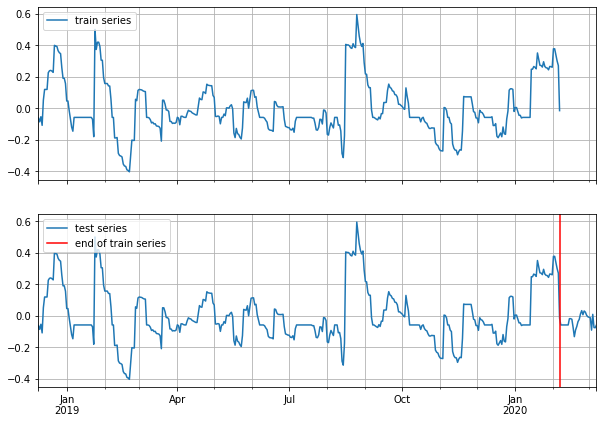

In [32]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

### Building an estimator

Now, we can create a simple training network that defines a neural network that takes as input a window of length `context_length` and predicts the subsequent window of dimension `prediction_length` (thus, the output dimension of the network is `prediction_length`). The hybrid_forward method of the training network returns the mean of the L1 loss. Recall that the L1 loss is the mean absolute error, given in Python as 

```
def L1(yHat, y):
    return np.sum(np.absolute(yHat - y))
```
where `yHat` is the vector of predicted values, & `y` is the vector of actual values. Mathematically, this is given by:


$${\displaystyle \mathrm {MAE} ={\frac {\sum _{i=1}^{n}\left|y_{i}-x_{i}\right|}{n}}={\frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}}.}$$


The prediction network is (and should be) identical to the training network (by inheriting the class) and its `hybrid_forward` method returns the predictions.

(The code for this & other networks, which are pretty hefty blocks of code, have been moved to the nwnetworks module, to make the notebook a little tidier).

After defining the training and prediction network, as well as the estimator class, we can follow exactly the same steps as with the existing models, i.e., we can specify our estimator by passing all the required hyperparameters to the estimator class, train the estimator by invoking its `train` method to create a predictor, and finally use the `make_evaluation_predictions` function to generate our forecasts.

In [33]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.trainer import Trainer
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter
from mxnet.gluon import HybridBlock

In [34]:
estimator = nwn.MyEstimator(
    prediction_length=nw_ds_metadata['prediction_length'],
    context_length=2*nw_ds_metadata['prediction_length'],
    freq=nw_ds_metadata['freq'],
    num_cells=40,
    trainer=Trainer(ctx="cpu", 
                    epochs=50, 
                    learning_rate=1e-4, 
                    hybridize=False, 
                    num_batches_per_epoch=100
                   )
)

The estimator can be trained using our training dataset `train_ds` by invoking its `train` method. The training returns a predictor.

In [35]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 255.78it/s, epoch=44/50, avg_epoch_loss=0.121]


Gluon also provides backtesting evaluation methods.

In [36]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

In [37]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [38]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [39]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 123/123 [00:00<00:00, 1585.96it/s]


The evaluator gives a useful set of metrics, as can be seen below:

In [40]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.03014088293744458,
    "abs_error": 455.61242440342903,
    "abs_target_sum": 452.4546788036823,
    "abs_target_mean": 0.12261644412023912,
    "seasonal_error": 0.023236029484389405,
    "MASE": 6.32219340871051,
    "MAPE": 1.465998282687982,
    "sMAPE": 1.7105166285799893,
    "OWA": NaN,
    "MSIS": 252.88773918823549,
    "QuantileLoss[0.1]": 475.78061986250833,
    "Coverage[0.1]": 0.5403794037940379,
    "QuantileLoss[0.5]": 455.61242670295906,
    "Coverage[0.5]": 0.5403794037940379,
    "QuantileLoss[0.9]": 435.4442335434098,
    "Coverage[0.9]": 0.5403794037940379,
    "RMSE": 0.1736112984152949,
    "NRMSE": 1.415889195457745,
    "ND": 1.0069791423266878,
    "wQuantileLoss[0.1]": 1.0515542045459696,
    "wQuantileLoss[0.5]": 1.006979147409031,
    "wQuantileLoss[0.9]": 0.9624040902720926,
    "mean_wQuantileLoss": 1.0069791474090313,
    "MAE_Coverage": 0.280126467931346
}


So we can see that this vanilla network performed _resaonably_ well, with, for example, a small mean squared error. 

### Probabilistic forecasting with a DNN

Probabilistic forecasting requires that we learn the _distribution_ of the future values of the time series and not the values themselves as in point forecasting. To achieve this, we need to specify the type of distribution that the future values follow.

Each distribution comes with a `DistributionOutput` class (e.g., `GaussianOutput`). The role of this class is to connect a model with a distribution. Its main usage is to take the output of the model and map it to the parameters of the distribution. You can think of it as an additional projection layer on top of the model. The parameters of this layer are optimized along with the rest of the network.

Again, the code for this module is in the accompnaying module, to keep the notebook relatively compact.

In [41]:
from gluonts.distribution.distribution_output import DistributionOutput
from gluonts.distribution.gaussian import GaussianOutput

In [42]:
estimator = nwn.MyProbEstimator(
    prediction_length=nw_ds_metadata['prediction_length'],
    context_length=2*nw_ds_metadata['prediction_length'],
    freq=nw_ds_metadata['freq'],
    distr_output=GaussianOutput(),
    num_cells=40,
    trainer=Trainer(ctx="cpu", 
                    epochs=50, 
                    learning_rate=1e-4, 
                    hybridize=False, 
                    num_batches_per_epoch=100
                   )
)

In [43]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 215.13it/s, epoch=50/50, avg_epoch_loss=-.587]


In [44]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

Now we can evaluate how well this network has performed with the prediction task.

In [45]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [46]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 123/123 [00:00<00:00, 1992.56it/s]


In [47]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.023010324581140065,
    "abs_error": 387.9204583466053,
    "abs_target_sum": 452.4546788036823,
    "abs_target_mean": 0.12261644412023912,
    "seasonal_error": 0.023236029484389405,
    "MASE": 5.019073988254085,
    "MAPE": 3.3782364867210037,
    "sMAPE": 1.2079571980354855,
    "OWA": NaN,
    "MSIS": 45.75675446187963,
    "QuantileLoss[0.1]": 217.87458174563946,
    "Coverage[0.1]": 0.10162601626016259,
    "QuantileLoss[0.5]": 387.92045677569695,
    "Coverage[0.5]": 0.5121951219512194,
    "QuantileLoss[0.9]": 186.94960540598257,
    "Coverage[0.9]": 0.9073170731707317,
    "RMSE": 0.15169154419788886,
    "NRMSE": 1.2371223557024567,
    "ND": 0.8573686526400623,
    "wQuantileLoss[0.1]": 0.4815390180552737,
    "wQuantileLoss[0.5]": 0.857368649168094,
    "wQuantileLoss[0.9]": 0.41318968321929767,
    "mean_wQuantileLoss": 0.5840324501475551,
    "MAE_Coverage": 0.007046070460704569
}


We can also make a plot comparing the actual & forecast values for a time series.

In [48]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

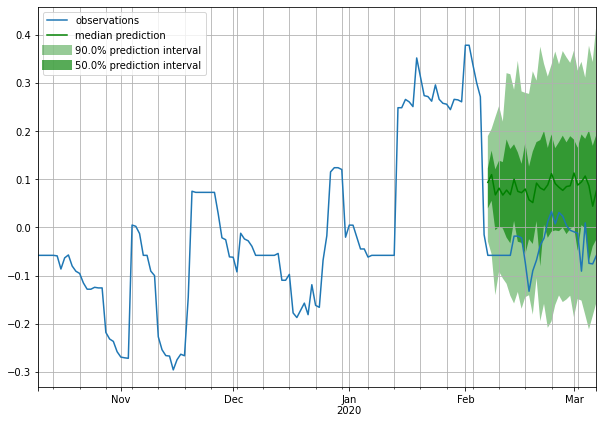

In [49]:
plot_prob_forecasts(tss[0], forecasts[0])

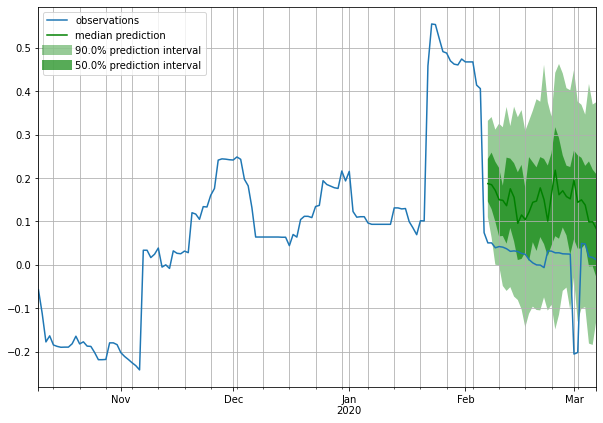

In [50]:
plot_prob_forecasts(tss[13], forecasts[13])

As can be seen, the predictions (distributions of predicted values) are not unreasonable.

### Recurrent neural networks

In previous examples, we  used a feedforward neural network as the base for our forecasting model. The main idea behind it was to use as an input to the network a window of the time series (of length `context_length`) and train the network to forecast the following window (of length `prediction_length`). 

Recurrent neural networks have been successfully used in natural language processing and time series analysis tasks, & they are obviously suited to modelling the current task. In this section, we replace the feedforward network with a recurrent neural network (RNN). Due to the different nature of RNNs the structure of the networks will be a bit different. 

The main idea behind RNNs is the same as in the feedforward networks we already constructed: as we unroll the RNN at each time step we use as an input past values of the time series and forecast the next value. We can enhance the input by using multiple past values (for example specific lags based on seasonality patterns) or available features. However, in this example we will keep things simple and just use the last value of the time series. The output of the network at each time step is the distribution of the value of the next time step, where the state of the RNN is used as the feature vector for the parameter projection of the distribution.

Due to the sequential nature of the RNN, the distinction between `past_` and `future_` in the cut window of the time series is not really necessary. Therefore, we can concatenate `past_target` and `future_target ` and treat it as a concrete `target` window that we wish to forecast. This means that the input to the RNN would be (sequentially) the window `target[-(context_length + prediction_length + 1):-1]` (one time step before the window we want to predict). As a consequence, we need to have `context_length + prediction_length + 1` available values at each window that we cut. We can define this in the `InstanceSplitter`. 

#### Training


During training we have the following steps:

- We pass sequentially through the RNN the target values `target[-(context_length + prediction_length + 1):-1]` 
- We use the state of the RNN at each time step as a feature vector and project it to the distribution parameter domain
- The output at each time step is the distribution of the values of the next time step, which overall is the forecasted distribution for the window `target[-(context_length + prediction_length):]`

The above steps are implemented in the `unroll_encoder` method (given in the Python module).

#### Inference

During inference we know the values only of `past_target` therefore we cannot follow exactly the same steps as in training. However the main idea is very similar:

- We pass sequentially through the RNN the past target values `past_target[-(context_length + 1):]` that effectively updates the state of the RNN
- In the last time step the output of the RNN is effectively the distribution of the next value of the time series (which we do not know). Therefore we sample (`num_sample_paths` times) from this distribution and use the samples as inputs to the RNN for the next time step
- We repeat the previous step `prediction_length` times 

The first step is implemented in `unroll_encoder` and the last steps in the `sample_decoder` method.

In [51]:
from gluonts.block.scaler import MeanScaler, NOPScaler
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

In [52]:
estimator = nwn.MyProbRNNEstimator(
        prediction_length=30,
        context_length=60,
        freq="1D",
        num_cells=60,
        num_layers=4,
        distr_output=GaussianOutput(),
        trainer=Trainer(ctx="cpu",
                        epochs=50,
                        learning_rate=1e-4,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )

In [ ]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


 64%|██████▍   | 64/100 [00:20<00:11,  3.13it/s, epoch=9/50, avg_epoch_loss=-1.43]

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [ ]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

In [ ]:
plot_prob_forecasts(tss[0], forecasts[0])

In [ ]:
plot_prob_forecasts(tss[2], forecasts[2])

As expected, the RNN model gives more accurate forecasts than the DNN models we employed earlier.  

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

In [ ]:
print(json.dumps(agg_metrics, indent=4))